In [3]:
##########################################################複製區塊
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys
import meep as mp
import numpy as np
import random
import multiprocessing as multi
#setup some constants and parameters
M=2**16
tsim=7e-12
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=3000
frq_min = 0.5 #150THz
frq_max = 0.8 #240THz
nfreq = 1000
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp= 20
nfreq =  1000
#define the starting sum of the result
epsilonA = 2
epsilonB = 13
Efsum = np.zeros(nfreq)
Ens = np.zeros(2*M)
resolution = 60
va = 1
dA = 0.2
dB = 0.8
dpml = 1.0
NAB = 6
sz = 2*dpml+(dA+dB)*NAB+2*va
cell = mp.Vector3(0, 0, sz)
pml_layers = [mp.PML(dpml)]



for i in range(Ncomp):
    
    def random_En(t):
        #generate random numbers
        M0 = np.random.normal(0,1)
        Mlp = np.random.normal(0,1,M-1)
        Nlp = np.random.normal(0,1,M-1)
        MM = np.random.normal(0,1)
    
        #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
        #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
        #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
        Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
        Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
        Eflm = np.flip(np.conjugate(Eflp))
        EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
        Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
        #we normalize Ef and compute its inverse fast fourier transform
        Efn = deltap*T/np.sqrt(tsim)*Ef
        En = np.fft.ifft(Efn)*M
        return En
    En0 = random_En(1)
    En1 = random_En(1)
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('a'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)
    
    
    def source0(t):
        f = int(t*10)
        return En0[f]
    def source1(t):
        f = int(t*10)
        return En1[f]
   


    sources = [mp.Source(mp.CustomSource(src_func=source0),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,random.uniform(-(dA+dB)*NAB/2-va,-(dA+dB)*NAB/2)),
                     ),
              mp.Source(mp.CustomSource(src_func=source1),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,random.uniform((dA+dB)*NAB/2,(dA+dB)*NAB/2+va)),
                     )
              ]
    
    def BlockAB(N, center):
        geometry = []
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,va),
                         center=mp.Vector3(z=center-(dA+dB)*N/2 - va/2 ),
                         material=mp.Medium(epsilon=1)))
        for i in range(N):
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                         center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dA/2),
                         material=mp.Medium(epsilon=epsilonA)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dB),
                         center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dA + dB/2),
                         material=mp.Medium(epsilon=epsilonB)))
        geometry = geometry.tolist()
        return geometry
    def BlockBA(N, center):
        geometry = []
        
        for i in range(N):
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dB),
                         center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dB/2),
                         material=mp.Medium(epsilon=epsilonB)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                         center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dB + dA/2),
                         material=mp.Medium(epsilon=epsilonA)))
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,va),
                         center=mp.Vector3(z=center + (dA+dB)*N/2 + va/2 ),
                         material=mp.Medium(epsilon=1)))
        geometry = geometry.tolist()
        return geometry
    geometry = sum([BlockAB(3,-3*(dA+dB)/2),BlockBA(3,3*(dA+dB)/2)],[])

    
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,   
                    dimensions = 1,
                    Courant = 1,
                    resolution=resolution,
                    geometry=geometry)
    
    

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(0,0,random.uniform(-(dA+dB)*NAB/2,(dA+dB)*NAB/2)))
    tran = sim.add_energy(fcen, df, nfreq, tran_fr)
    
    
    sim.run(until=300)

    tran_flux = mp.get_magnetic_energy(tran)
    Ts = []
    for i in range(nfreq):
        Ts = np.append(Ts,tran_flux[i])    
    Efsum = Ts
    
    

#average the final result
Efavg = Efsum/Ncomp

#save data to some file or reload file to write more data on it


[                    ] 0%-----------
Initializing structure...
time for choose_chunkdivision = 8.79765e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,1

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaa               ] 5%-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
         

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaa          ] 10%-----------
Initializing structure...
time for choose_chunkdivision = 8.89301e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
       

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaa     ] 15%-----------
Initializing structure...
time for choose_chunkdivision = 8.39233e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
       

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaa] 20%-----------
Initializing structure...
time for choose_chunkdivision = 8.79765e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
       

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaa] 25%-----------
Initializing structure...
time for choose_chunkdivision = 8.70228e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
  

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 30%-----------
Initializing structure...
time for choose_chunkdivision = 8.79765e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 35%-----------
Initializing structure...
time for choose_chunkdivision = 8.2016e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 40%-----------
Initializing structure...
time for choose_chunkdivision = 8.79765e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 45%-----------
Initializing structure...
time for choose_chunkdivision = 9.01222e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0),

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 50%-----------
Initializing structure...
time for choose_chunkdivision = 8.2016e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axes (1,0

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 55%-----------
Initializing structure...
time for choose_chunkdivision = 8.98838e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
          axe

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 60%-----------
Initializing structure...
time for choose_chunkdivision = 7.82013e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
        

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 65%-----------
Initializing structure...
time for choose_chunkdivision = 8.10623e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8)
   

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 70%-----------
Initializing structure...
time for choose_chunkdivision = 7.98702e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+20,0.8

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 75%-----------
Initializing structure...
time for choose_chunkdivision = 7.70092e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20,1e+2

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 80%-----------
Initializing structure...
time for choose_chunkdivision = 7.70092e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (1e+20

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 85%-----------
Initializing structure...
time for choose_chunkdivision = 7.79629e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          size (

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 90%-----------
Initializing structure...
time for choose_chunkdivision = 8.58307e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
          s

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 95%-----------
Initializing structure...
time for choose_chunkdivision = 8.79765e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.4)
      

FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (18000 timesteps)


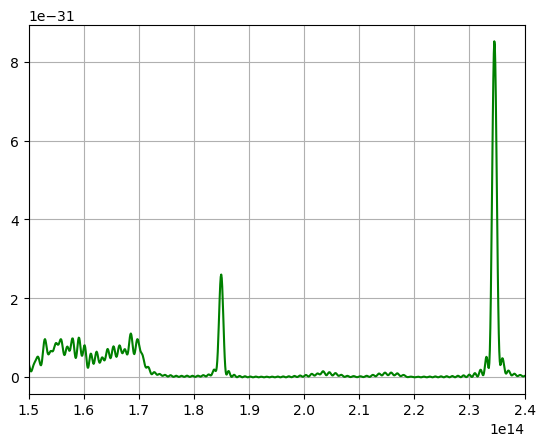

In [6]:
freqs = np.linspace(1.5e14,2.4e14,1000)
plt.plot(freqs,Efavg*tsim*eps0*4*np.pi*3/M,'g''-')
plt.xlim(1.5e14,2.4e14)
#plt.yscale("log")
#plt.ylim(0.1e-28,400e-28)
plt.grid()
plt.savefig('1.5_2.4sim116.png')
plt.show()

#np.savez("3ABBA1000.npz", Efavg_30000 = Efavg)